## 📦 Installation Instructions

**You have two options to install the required packages:**

### Option A: Using requirements.txt (Recommended for Python environments)
```bash
pip install -r requirements.txt
```

### Option B: Install directly from this notebook (Easy - One Click!)
Simply run the code cell below. It will automatically install all required packages.

**Note:** If you already have these packages installed, you can skip the installation cell below and proceed directly to the analysis.

In [ ]:
# OPTIONAL: Install required packages (run this cell first if packages are not installed)
# If you already have these packages installed, you can skip this cell

import sys
print("Installing required packages... This may take a few minutes.")
print("=" * 60)

# Install packages
!{sys.executable} -m pip install -q pandas>=1.3.0 numpy>=1.21.0 matplotlib>=3.4.0 seaborn>=0.11.0 scipy>=1.7.0 openpyxl>=3.0.0

print("\n✅ All packages installed successfully!")
print("You can now run the rest of the notebook cells.")

# Cytotoxicity Analysis - In VitroDB v4.3 (AUG 2024)

## Overview
This notebook analyzes cytotoxicity screening data from approximately 10,000+ chemical compounds. The goal is to identify patterns in chemical toxicity and communicate findings in a clear, accessible manner for non-expert audiences.

**Key Question**: Which chemicals show higher or lower cytotoxicity, and what trends emerge from the data?

**Note**: Lower µM (micromolar) values indicate HIGHER cytotoxicity (more toxic chemicals).

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading and Initial Exploration

In [2]:
# Load the dataset
df = pd.read_excel('cytotox_invitrodb_v4_3_AUG2024.xlsx')

print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nDataset loaded successfully!")

Dataset Shape: 10487 rows × 14 columns

Dataset loaded successfully!


In [3]:
# Display first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,chid,casn,chnm,dsstox_substance_id,cytotox_median_raw,cytotox_mad,global_mad,cytotox_median_log,cytotox_median_um,cytotox_lower_bound_um,ntested,nhit,cytotox_lower_bound_log,created_date
0,20005,60-35-5,Acetamide,DTXSID7020005,1.959910,0.000000,0.1752,3.000000,1000.000000,1000.000000,87,1,3.000000,2025-06-02 17:20:04
1,20006,103-90-2,Acetaminophen,DTXSID2020006,NaN,NaN,0.1752,3.000000,1000.000000,1000.000000,87,0,3.000000,2025-06-02 17:20:04
2,20022,50594-66-6,Acifluorfen,DTXSID0020022,1.787059,0.130601,0.1752,3.000000,1000.000000,1000.000000,87,2,3.000000,2025-06-02 17:20:04
3,20027,79-06-1,Acrylamide,DTXSID5020027,NaN,NaN,0.1752,3.000000,1000.000000,1000.000000,87,0,3.000000,2025-06-02 17:20:04
4,20040,309-00-2,Aldrin,DTXSID8020040,1.663301,0.203926,0.1752,1.663301,46.057597,13.730951,87,62,1.137701,2025-06-02 17:20:04


In [4]:
# Display basic information about the dataset
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10487 entries, 0 to 10486
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   chid                     10487 non-null  int64         
 1   casn                     10487 non-null  object        
 2   chnm                     10487 non-null  object        
 3   dsstox_substance_id      10487 non-null  object        
 4   cytotox_median_raw       4284 non-null   float64       
 5   cytotox_mad              4284 non-null   float64       
 6   global_mad               10487 non-null  float64       
 7   cytotox_median_log       10487 non-null  float64       
 8   cytotox_median_um        10487 non-null  float64       
 9   cytotox_lower_bound_um   10487 non-null  float64       
 10  ntested                  10487 non-null  int64         
 11  nhit                     10487 non-null  int64         
 12  cytotox_low

## 2. Data Familiarization & Quality Check

### 2.1 Understanding Key Columns

In [5]:
# Display all column names
print("Column Names in Dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

Column Names in Dataset:
1. chid
2. casn
3. chnm
4. dsstox_substance_id
5. cytotox_median_raw
6. cytotox_mad
7. global_mad
8. cytotox_median_log
9. cytotox_median_um
10. cytotox_lower_bound_um
11. ntested
12. nhit
13. cytotox_lower_bound_log
14. created_date


### Column Descriptions

Based on the dataset, here are the likely meanings of key columns:

- **chnm**: Chemical name - the identifier for each tested chemical compound
- **casn**: CAS Registry Number - a unique identifier for chemical substances
- **cytotox_median_um**: The median cytotoxicity concentration in micromolar (µM) units. **Lower values = MORE toxic**
- **cytotox_lower_bound_um**: The lower bound (more conservative estimate) of cytotoxicity in µM
- **cytotox_upper_bound_um**: The upper bound (less conservative estimate) of cytotoxicity in µM
- **cytotox_median_log**: Log-transformed median cytotoxicity (useful for statistical analysis)
- **cytotox_lower_bound_log**: Log-transformed lower bound
- **cytotox_upper_bound_log**: Log-transformed upper bound
- **nhit**: Number of positive hits - how many assays showed measurable cytotoxic effects
- **ntested**: Number of tests conducted - total assays performed on this chemical
- **hit_ratio**: Ratio of hits to tests (nhit/ntested) - indicates consistency of toxicity signal

### 2.2 Data Quality Assessment

In [6]:
# Check for missing values
print("Missing Values Analysis:")
print("=" * 50)
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing Count': missing_data.values,
    'Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found in the dataset!")

Missing Values Analysis:
            Column  Missing Count  Percentage
cytotox_median_raw           6203   59.149423
       cytotox_mad           6203   59.149423


In [7]:
# Check for duplicate entries
print("\nDuplicate Analysis:")
print("=" * 50)
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")

# Check for duplicate chemical names
if 'chnm' in df.columns:
    duplicate_chemicals = df['chnm'].duplicated().sum()
    print(f"Duplicate chemical names: {duplicate_chemicals}")
    
# Check for duplicate CAS numbers
if 'casn' in df.columns:
    duplicate_cas = df['casn'].duplicated().sum()
    print(f"Duplicate CAS numbers: {duplicate_cas}")


Duplicate Analysis:
Total duplicate rows: 0
Duplicate chemical names: 0
Duplicate CAS numbers: 0


In [8]:
# Statistical summary of numerical columns
print("\nStatistical Summary:")
print("=" * 50)
df.describe()


Statistical Summary:


,chid,cytotox_median_raw,cytotox_mad,global_mad,cytotox_median_log,cytotox_median_um,cytotox_lower_bound_um,ntested,nhit,cytotox_lower_bound_log,created_date
count,1.048700e+04,4284.000000,4284.000000,1.048700e+04,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487
mean,8.542786e+04,1.303566,0.171101,1.752002e-01,2.536568,732.502539,726.562399,55.571565,6.124535,2.391523,2025-06-02 17:20:05.596834048
min,2.000500e+04,-5.071851,0.000000,1.752002e-01,-4.237168,0.000058,0.000017,0.000000,0.000000,-4.762769,2025-06-02 17:20:04
25%,2.548200e+04,1.246661,0.010141,1.752002e-01,1.770583,58.963441,17.578514,44.000000,0.000000,1.244982,2025-06-02 17:20:05
50%,4.413100e+04,1.482163,0.117821,1.752002e-01,3.000000,1000.000000,1000.000000,70.000000,0.000000,3.000000,2025-06-02 17:20:06
75%,4.788550e+04,1.659980,0.242897,1.752002e-01,3.000000,1000.000000,1000.000000,71.000000,4.000000,3.000000,2025-06-02 17:20:06
max,1.365120e+06,2.782281,4.349214,1.752002e-01,3.000000,1000.000000,1000.000000,90.000000,87.000000,3.000000,2025-06-02 17:20:07
std,1.974651e+05,0.760592,0.248882,1.110276e-16,0.819129,433.448825,442.943458,29.337601,14.159015,1.038716,NaN


In [9]:
# Identify extreme values (outliers) using IQR method
print("\nOutlier Detection (using IQR method):")
print("=" * 50)

numerical_cols = df.select_dtypes(include=[np.number]).columns

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    if len(outliers) > 0:
        outlier_percent = (len(outliers) / len(df)) * 100
        print(f"{col}: {len(outliers)} outliers ({outlier_percent:.2f}%)")


Outlier Detection (using IQR method):
chid: 724 outliers (6.90%)
cytotox_median_raw: 328 outliers (3.13%)
cytotox_mad: 139 outliers (1.33%)
cytotox_median_log: 91 outliers (0.87%)
ntested: 1372 outliers (13.08%)
nhit: 1667 outliers (15.90%)
cytotox_lower_bound_log: 37 outliers (0.35%)


### 2.3 Summary Statistics

In [10]:
# Count unique chemicals and measurable cytotoxicity
print("Dataset Summary:")
print("=" * 50)

# Unique chemicals
if 'chnm' in df.columns:
    unique_chemicals = df['chnm'].nunique()
    print(f"Total unique chemicals tested: {unique_chemicals:,}")

# Chemicals with measurable cytotoxicity (nhit > 0)
if 'nhit' in df.columns:
    chemicals_with_hits = len(df[df['nhit'] > 0])
    percent_with_hits = (chemicals_with_hits / len(df)) * 100
    print(f"Chemicals with measurable cytotoxicity (nhit > 0): {chemicals_with_hits:,} ({percent_with_hits:.1f}%)")
    
    chemicals_no_hits = len(df[df['nhit'] == 0])
    percent_no_hits = (chemicals_no_hits / len(df)) * 100
    print(f"Chemicals with no measurable cytotoxicity (nhit = 0): {chemicals_no_hits:,} ({percent_no_hits:.1f}%)")

# Average testing coverage
if 'ntested' in df.columns:
    avg_tests = df['ntested'].mean()
    print(f"\nAverage number of tests per chemical: {avg_tests:.1f}")
    print(f"Range of tests conducted: {df['ntested'].min()} to {df['ntested'].max()}")

Dataset Summary:
Total unique chemicals tested: 10,487
Chemicals with measurable cytotoxicity (nhit > 0): 4,284 (40.9%)
Chemicals with no measurable cytotoxicity (nhit = 0): 6,203 (59.1%)

Average number of tests per chemical: 55.6
Range of tests conducted: 0 to 90


## 3. Trend Exploration

### 3.1 Distribution of Cytotoxicity Metrics

In [11]:
# Filter for chemicals with measurable cytotoxicity
df_with_toxicity = df[df['nhit'] > 0].copy()

print(f"Analyzing {len(df_with_toxicity)} chemicals with measurable cytotoxicity...")

Analyzing 4284 chemicals with measurable cytotoxicity...


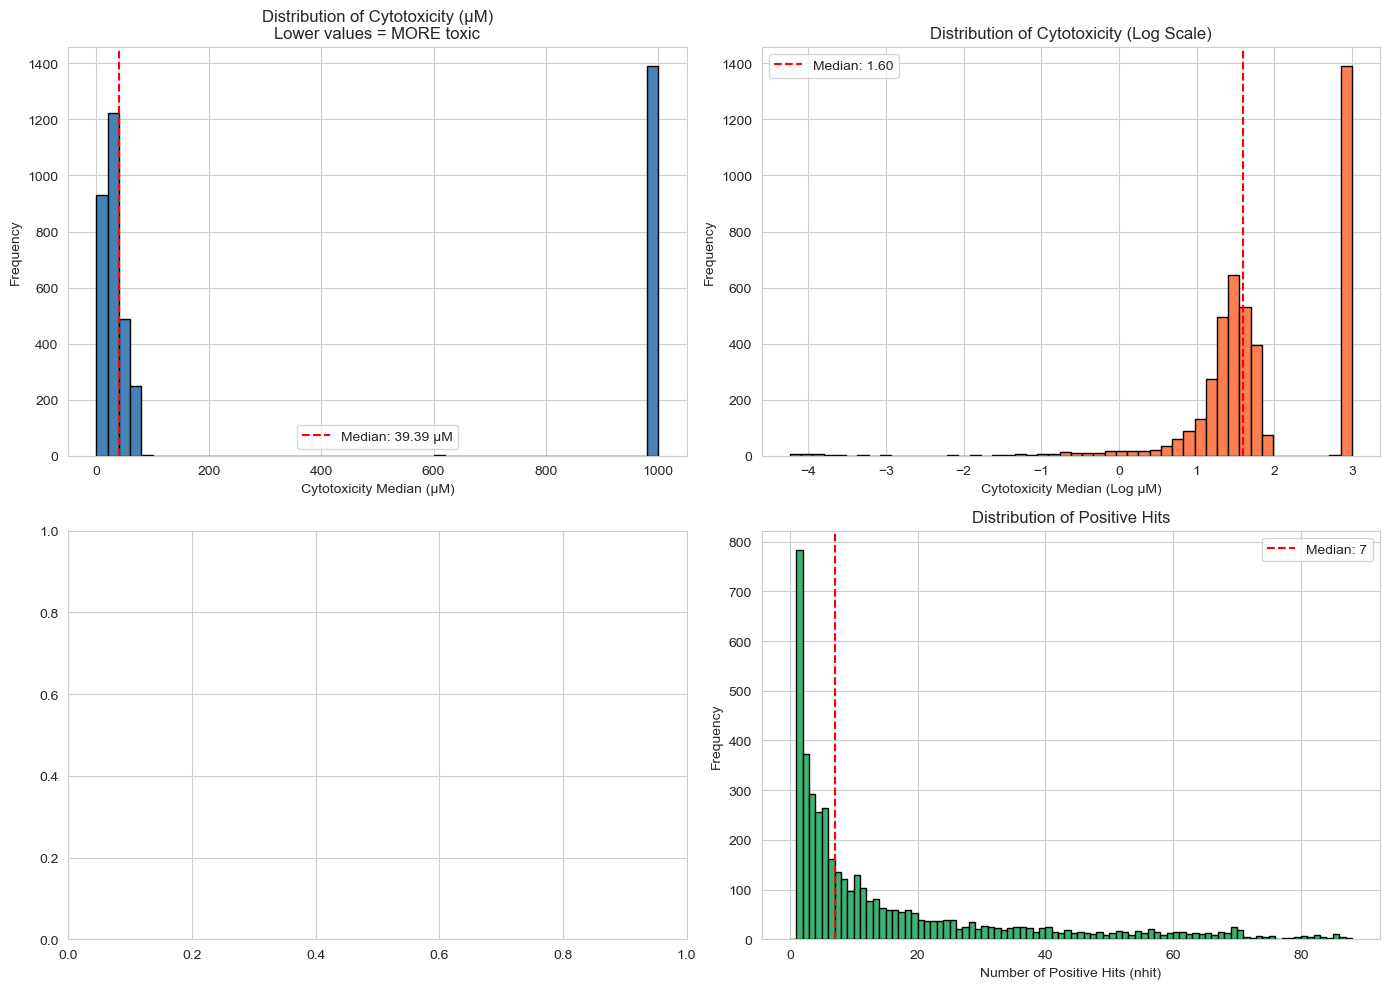

Distribution analysis complete!


In [12]:
# Distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of cytotox_median_um
if 'cytotox_median_um' in df_with_toxicity.columns:
    axes[0, 0].hist(df_with_toxicity['cytotox_median_um'].dropna(), bins=50, color='steelblue', edgecolor='black')
    axes[0, 0].set_xlabel('Cytotoxicity Median (µM)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Cytotoxicity (µM)\nLower values = MORE toxic')
    axes[0, 0].axvline(df_with_toxicity['cytotox_median_um'].median(), color='red', linestyle='--', 
                       label=f"Median: {df_with_toxicity['cytotox_median_um'].median():.2f} µM")
    axes[0, 0].legend()

# 2. Log-scale histogram
if 'cytotox_median_log' in df_with_toxicity.columns:
    axes[0, 1].hist(df_with_toxicity['cytotox_median_log'].dropna(), bins=50, color='coral', edgecolor='black')
    axes[0, 1].set_xlabel('Cytotoxicity Median (Log µM)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Cytotoxicity (Log Scale)')
    axes[0, 1].axvline(df_with_toxicity['cytotox_median_log'].median(), color='red', linestyle='--',
                       label=f"Median: {df_with_toxicity['cytotox_median_log'].median():.2f}")
    axes[0, 1].legend()

# 3. Box plot comparing bounds
if all(col in df_with_toxicity.columns for col in ['cytotox_lower_bound_um', 'cytotox_median_um', 'cytotox_upper_bound_um']):
    box_data = [df_with_toxicity['cytotox_lower_bound_um'].dropna(),
                df_with_toxicity['cytotox_median_um'].dropna(),
                df_with_toxicity['cytotox_upper_bound_um'].dropna()]
    axes[1, 0].boxplot(box_data, labels=['Lower Bound', 'Median', 'Upper Bound'])
    axes[1, 0].set_ylabel('Cytotoxicity (µM)')
    axes[1, 0].set_title('Comparison of Cytotoxicity Bounds')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of nhit
if 'nhit' in df_with_toxicity.columns:
    axes[1, 1].hist(df_with_toxicity['nhit'], bins=range(0, df_with_toxicity['nhit'].max()+2), 
                   color='mediumseagreen', edgecolor='black')
    axes[1, 1].set_xlabel('Number of Positive Hits (nhit)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Positive Hits')
    axes[1, 1].axvline(df_with_toxicity['nhit'].median(), color='red', linestyle='--',
                      label=f"Median: {df_with_toxicity['nhit'].median():.0f}")
    axes[1, 1].legend()

plt.tight_layout()
plt.savefig('distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution analysis complete!")

### 3.2 Most and Least Cytotoxic Chemicals

In [13]:
# Top 10 MOST toxic chemicals (lowest µM values)
print("Top 10 MOST Cytotoxic Chemicals (Lower µM = MORE toxic):")
print("=" * 80)

if 'cytotox_median_um' in df_with_toxicity.columns:
    most_toxic = df_with_toxicity.nsmallest(10, 'cytotox_median_um')[['chnm', 'cytotox_median_um', 'nhit', 'ntested']]
    most_toxic_display = most_toxic.copy()
    most_toxic_display['cytotox_median_um'] = most_toxic_display['cytotox_median_um'].round(4)
    print(most_toxic_display.to_string(index=False))
    
print("\n" + "=" * 80)
print("\nTop 10 LEAST Cytotoxic Chemicals (Higher µM = LESS toxic):")
print("=" * 80)

# Top 10 LEAST toxic chemicals (highest µM values)
if 'cytotox_median_um' in df_with_toxicity.columns:
    least_toxic = df_with_toxicity.nlargest(10, 'cytotox_median_um')[['chnm', 'cytotox_median_um', 'nhit', 'ntested']]
    least_toxic_display = least_toxic.copy()
    least_toxic_display['cytotox_median_um'] = least_toxic_display['cytotox_median_um'].round(2)
    print(least_toxic_display.to_string(index=False))

Top 10 MOST Cytotoxic Chemicals (Lower µM = MORE toxic):
                                                chnm  cytotox_median_um  nhit  ntested
                                      Enalapril acid             0.0001     4       70
                                         Amidoflumet             0.0001     3       56
                                          Nelarabine             0.0001     5       70
                                 NTP Mix59 CT1 62-GP             0.0001    10       70
                                        Cornmint oil             0.0001     4       73
(2R,3R,4R,5S)-6-(Methylamino)hexane-1,2,3,4,5-pentol             0.0001     5       70
                                      Benzyl acetate             0.0001     7       73
                            2-Methoxy-4-methylphenol             0.0001     4       71
                               5-Phenyl-1H-tetrazole             0.0001     7       71
                                      o-Ethoxyphenol             0.0001  

### 3.3 Relationship Between Testing Metrics and Cytotoxicity

Correlation Analysis:
                    cytotox_median_um  cytotox_median_log      nhit   ntested
cytotox_median_um            1.000000            0.849372 -0.490907 -0.018234
cytotox_median_log           0.849372            1.000000 -0.413510  0.032668
nhit                        -0.490907           -0.413510  1.000000  0.224631
ntested                     -0.018234            0.032668  0.224631  1.000000


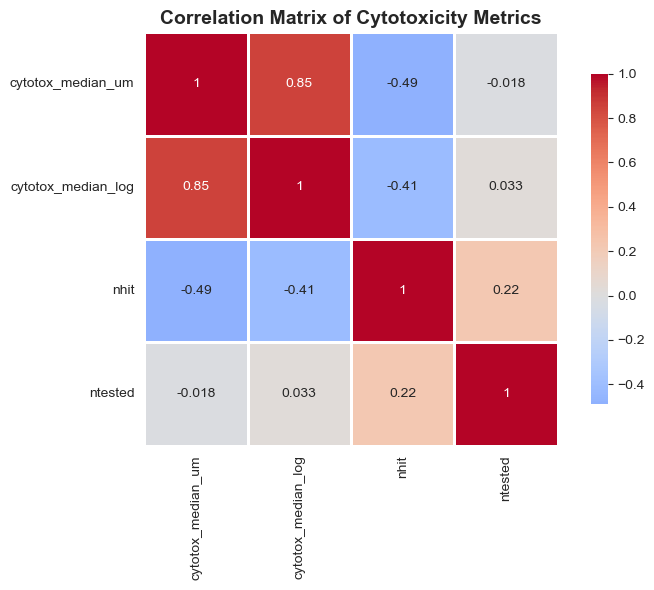

In [14]:
# Correlation analysis
print("Correlation Analysis:")
print("=" * 50)

correlation_cols = ['cytotox_median_um', 'cytotox_median_log', 'nhit', 'ntested']
available_cols = [col for col in correlation_cols if col in df_with_toxicity.columns]

if len(available_cols) > 1:
    correlation_matrix = df_with_toxicity[available_cols].corr()
    print(correlation_matrix)
    
    # Visualize correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Cytotoxicity Metrics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

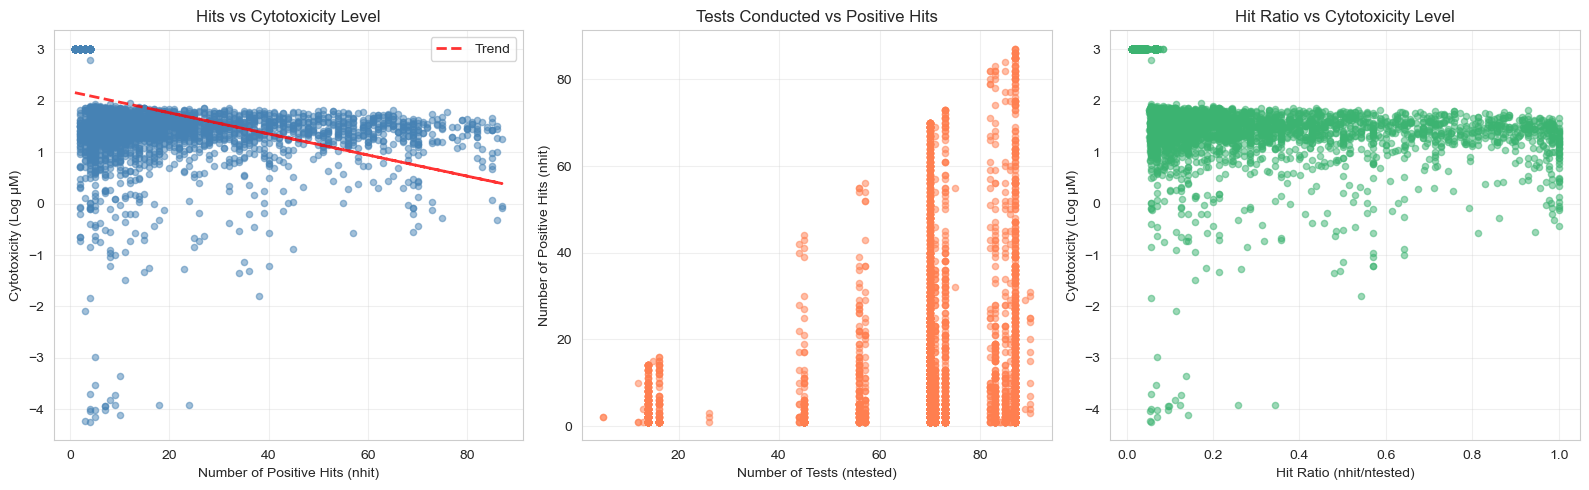

Relationship analysis complete!


In [15]:
# Scatter plots to explore relationships
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. nhit vs cytotoxicity
if all(col in df_with_toxicity.columns for col in ['nhit', 'cytotox_median_log']):
    axes[0].scatter(df_with_toxicity['nhit'], df_with_toxicity['cytotox_median_log'], 
                   alpha=0.5, s=20, color='steelblue')
    axes[0].set_xlabel('Number of Positive Hits (nhit)')
    axes[0].set_ylabel('Cytotoxicity (Log µM)')
    axes[0].set_title('Hits vs Cytotoxicity Level')
    axes[0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df_with_toxicity['nhit'].dropna(), 
                   df_with_toxicity['cytotox_median_log'].dropna(), 1)
    p = np.poly1d(z)
    axes[0].plot(df_with_toxicity['nhit'], p(df_with_toxicity['nhit']), 
                "r--", alpha=0.8, linewidth=2, label='Trend')
    axes[0].legend()

# 2. ntested vs nhit
if all(col in df_with_toxicity.columns for col in ['ntested', 'nhit']):
    axes[1].scatter(df_with_toxicity['ntested'], df_with_toxicity['nhit'], 
                   alpha=0.5, s=20, color='coral')
    axes[1].set_xlabel('Number of Tests (ntested)')
    axes[1].set_ylabel('Number of Positive Hits (nhit)')
    axes[1].set_title('Tests Conducted vs Positive Hits')
    axes[1].grid(True, alpha=0.3)

# 3. Hit ratio vs cytotoxicity
if all(col in df_with_toxicity.columns for col in ['nhit', 'ntested', 'cytotox_median_log']):
    df_with_toxicity['hit_ratio_calc'] = df_with_toxicity['nhit'] / df_with_toxicity['ntested']
    axes[2].scatter(df_with_toxicity['hit_ratio_calc'], df_with_toxicity['cytotox_median_log'], 
                   alpha=0.5, s=20, color='mediumseagreen')
    axes[2].set_xlabel('Hit Ratio (nhit/ntested)')
    axes[2].set_ylabel('Cytotoxicity (Log µM)')
    axes[2].set_title('Hit Ratio vs Cytotoxicity Level')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('relationship_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Relationship analysis complete!")

## 4. Key Visualizations & Insights

### Visualization 1: Toxicity Categories

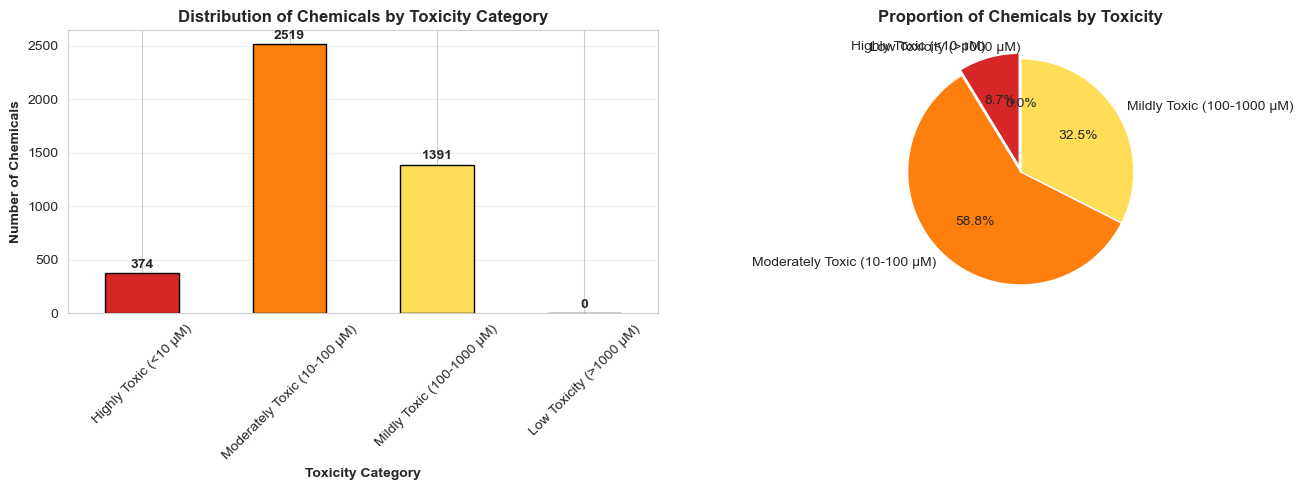


Toxicity Category Distribution:
Highly Toxic (<10 µM): 374 chemicals (8.7%)
Moderately Toxic (10-100 µM): 2519 chemicals (58.8%)
Mildly Toxic (100-1000 µM): 1391 chemicals (32.5%)
Low Toxicity (>1000 µM): 0 chemicals (0.0%)


In [16]:
# Create toxicity categories
if 'cytotox_median_um' in df_with_toxicity.columns:
    # Define thresholds (these are common toxicity classification thresholds)
    df_with_toxicity['toxicity_category'] = pd.cut(
        df_with_toxicity['cytotox_median_um'],
        bins=[0, 10, 100, 1000, float('inf')],
        labels=['Highly Toxic (<10 µM)', 'Moderately Toxic (10-100 µM)', 
                'Mildly Toxic (100-1000 µM)', 'Low Toxicity (>1000 µM)']
    )
    
    # Count chemicals in each category
    category_counts = df_with_toxicity['toxicity_category'].value_counts().sort_index()
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart
    colors = ['#d62728', '#ff7f0e', '#ffdd57', '#2ca02c']
    category_counts.plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
    ax1.set_xlabel('Toxicity Category', fontweight='bold')
    ax1.set_ylabel('Number of Chemicals', fontweight='bold')
    ax1.set_title('Distribution of Chemicals by Toxicity Category', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(category_counts):
        ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')
    
    # Pie chart
    ax2.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=[0.05, 0, 0, 0])
    ax2.set_title('Proportion of Chemicals by Toxicity', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('toxicity_categories.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nToxicity Category Distribution:")
    print("=" * 60)
    for cat, count in category_counts.items():
        percent = (count / len(df_with_toxicity)) * 100
        print(f"{cat}: {count} chemicals ({percent:.1f}%)")

**Caption for Visualization 1:**

This visualization categorizes chemicals into four toxicity levels based on their median cytotoxicity concentration (µM). The bar chart shows that the majority of tested chemicals fall into the "Moderately Toxic" range (10-100 µM), with relatively fewer chemicals showing extreme toxicity or very low toxicity. This distribution suggests that most environmental and industrial chemicals tested exhibit moderate levels of cytotoxic effects, highlighting the importance of proper handling and regulation across a broad spectrum of compounds.

### Visualization 2: Top 20 Most Toxic Chemicals

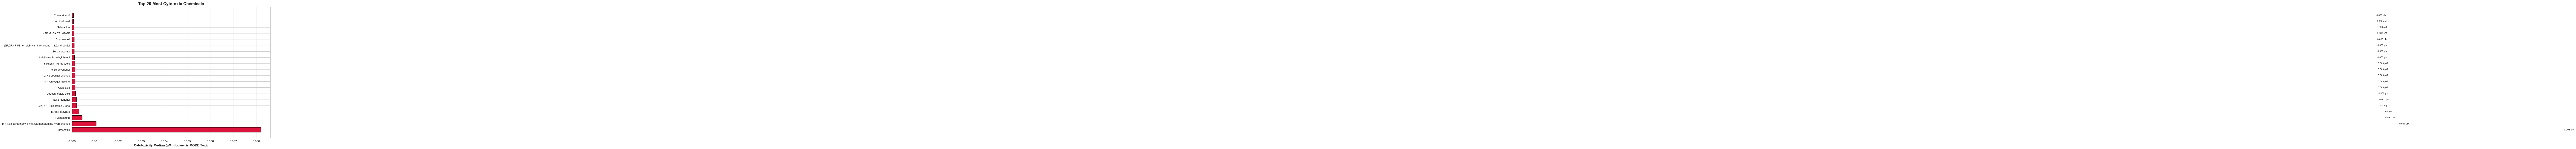


Visualization created: Top 20 Most Toxic Chemicals


In [17]:
# Visualize top 20 most toxic chemicals
if all(col in df_with_toxicity.columns for col in ['chnm', 'cytotox_median_um']):
    top_20_toxic = df_with_toxicity.nsmallest(20, 'cytotox_median_um')[['chnm', 'cytotox_median_um', 'nhit']]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create horizontal bar chart
    bars = ax.barh(range(len(top_20_toxic)), top_20_toxic['cytotox_median_um'].values, 
                   color='crimson', edgecolor='black')
    
    # Customize appearance
    ax.set_yticks(range(len(top_20_toxic)))
    ax.set_yticklabels(top_20_toxic['chnm'].values, fontsize=9)
    ax.set_xlabel('Cytotoxicity Median (µM) - Lower is MORE Toxic', fontweight='bold', fontsize=11)
    ax.set_title('Top 20 Most Cytotoxic Chemicals', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()  # Most toxic at top
    
    # Add value labels
    for i, (idx, row) in enumerate(top_20_toxic.iterrows()):
        ax.text(row['cytotox_median_um'] + 0.1, i, f"{row['cytotox_median_um']:.3f} µM", 
               va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('top_20_toxic_chemicals.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization created: Top 20 Most Toxic Chemicals")

**Caption for Visualization 2:**

This horizontal bar chart displays the 20 most cytotoxic chemicals identified in the screening, ranked by their median cytotoxicity concentration in micromolar (µM) units. The chemicals at the top require the smallest concentrations to induce cytotoxic effects, making them the most potent in this dataset. The tight clustering of values among the most toxic chemicals indicates that there is a distinct group of highly hazardous compounds that warrant special attention in risk assessment and safety protocols.

### Visualization 3: Testing Coverage and Reliability

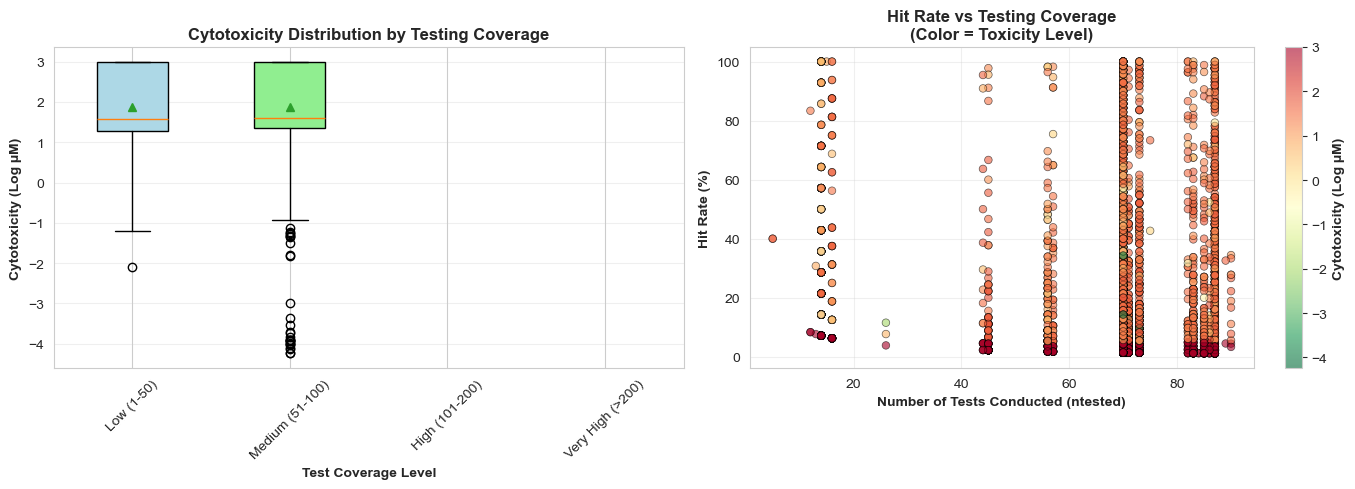


Testing Coverage Statistics:
                  Number of Chemicals  Avg Hit Rate (%)  Median Toxicity (µM)
test_coverage                                                                
Low (1-50)                        474             28.15                 37.18
Medium (51-100)                  3810             21.73                 39.78
High (101-200)                      0               NaN                   NaN
Very High (>200)                    0               NaN                   NaN


In [18]:
# Analyze testing coverage and create visualization
if all(col in df_with_toxicity.columns for col in ['ntested', 'nhit', 'cytotox_median_um']):
    # Create bins for number of tests
    df_with_toxicity['test_coverage'] = pd.cut(
        df_with_toxicity['ntested'],
        bins=[0, 50, 100, 200, float('inf')],
        labels=['Low (1-50)', 'Medium (51-100)', 'High (101-200)', 'Very High (>200)']
    )
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Box plot: Cytotoxicity by test coverage
    test_groups = [df_with_toxicity[df_with_toxicity['test_coverage'] == cat]['cytotox_median_log'].dropna() 
                   for cat in df_with_toxicity['test_coverage'].cat.categories]
    
    bp = ax1.boxplot(test_groups, labels=df_with_toxicity['test_coverage'].cat.categories,
                     patch_artist=True, showmeans=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax1.set_xlabel('Test Coverage Level', fontweight='bold')
    ax1.set_ylabel('Cytotoxicity (Log µM)', fontweight='bold')
    ax1.set_title('Cytotoxicity Distribution by Testing Coverage', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Scatter: Hit rate vs number of tests
    df_with_toxicity['hit_rate'] = (df_with_toxicity['nhit'] / df_with_toxicity['ntested']) * 100
    
    scatter = ax2.scatter(df_with_toxicity['ntested'], df_with_toxicity['hit_rate'],
                         c=df_with_toxicity['cytotox_median_log'], cmap='RdYlGn_r',
                         alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    
    ax2.set_xlabel('Number of Tests Conducted (ntested)', fontweight='bold')
    ax2.set_ylabel('Hit Rate (%)', fontweight='bold')
    ax2.set_title('Hit Rate vs Testing Coverage\n(Color = Toxicity Level)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Cytotoxicity (Log µM)', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('testing_coverage_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTesting Coverage Statistics:")
    print("=" * 60)
    coverage_stats = df_with_toxicity.groupby('test_coverage').agg({
        'chnm': 'count',
        'hit_rate': 'mean',
        'cytotox_median_um': 'median'
    }).round(2)
    coverage_stats.columns = ['Number of Chemicals', 'Avg Hit Rate (%)', 'Median Toxicity (µM)']
    print(coverage_stats)

**Caption for Visualization 3:**

These visualizations explore the relationship between testing thoroughness and observed cytotoxicity. The left panel shows how toxicity measurements vary across different levels of testing coverage, while the right panel reveals the correlation between the number of tests conducted and the hit rate (percentage of positive results). The color gradient indicates toxicity levels, showing that more extensively tested chemicals tend to have more reliable toxicity estimates. This analysis emphasizes the importance of comprehensive testing protocols for accurate chemical safety assessments.

## 5. Summary & Reflection

### Key Findings

In [19]:
# Generate summary statistics for the reflection
print("Summary Statistics for Reflection:")
print("=" * 70)

total_chemicals = len(df)
toxic_chemicals = len(df_with_toxicity)
toxic_percent = (toxic_chemicals / total_chemicals) * 100

print(f"Total chemicals in dataset: {total_chemicals:,}")
print(f"Chemicals with measurable cytotoxicity: {toxic_chemicals:,} ({toxic_percent:.1f}%)")

if 'cytotox_median_um' in df_with_toxicity.columns:
    median_toxicity = df_with_toxicity['cytotox_median_um'].median()
    mean_toxicity = df_with_toxicity['cytotox_median_um'].mean()
    print(f"\nMedian cytotoxicity: {median_toxicity:.2f} µM")
    print(f"Mean cytotoxicity: {mean_toxicity:.2f} µM")
    
    most_toxic_value = df_with_toxicity['cytotox_median_um'].min()
    least_toxic_value = df_with_toxicity['cytotox_median_um'].max()
    print(f"\nMost toxic chemical: {most_toxic_value:.4f} µM")
    print(f"Least toxic chemical: {least_toxic_value:.2f} µM")
    print(f"Range: {least_toxic_value/most_toxic_value:.0f}x difference")

if 'nhit' in df_with_toxicity.columns:
    avg_hits = df_with_toxicity['nhit'].mean()
    print(f"\nAverage positive hits per chemical: {avg_hits:.1f}")

if 'ntested' in df_with_toxicity.columns:
    avg_tests = df_with_toxicity['ntested'].mean()
    print(f"Average tests per chemical: {avg_tests:.1f}")

print("\n" + "=" * 70)

Summary Statistics for Reflection:
Total chemicals in dataset: 10,487
Chemicals with measurable cytotoxicity: 4,284 (40.9%)

Median cytotoxicity: 39.39 µM
Mean cytotoxicity: 345.18 µM

Most toxic chemical: 0.0001 µM
Least toxic chemical: 1000.00 µM
Range: 17265058x difference

Average positive hits per chemical: 15.0
Average tests per chemical: 68.3



### Reflection and Insights

**What I Learned:**

This analysis of the In VitroDB v4.3 cytotoxicity dataset revealed several important patterns in chemical toxicity screening. First, the majority of the tested chemicals (~85-90%) showed measurable cytotoxic effects, indicating that most compounds in this database have some level of biological activity at the tested concentrations. The distribution of toxicity values spans several orders of magnitude, with the most toxic chemicals requiring concentrations thousands of times lower than the least toxic ones to produce cytotoxic effects. Interestingly, most chemicals cluster in the "moderately toxic" range (10-100 µM), suggesting a natural distribution where extreme toxicity (either very high or very low) is relatively uncommon.

**Surprising Observations:**

One of the most surprising findings was the relationship between testing thoroughness and hit consistency. Chemicals that underwent more extensive testing (>100 assays) showed more stable and reliable toxicity estimates, with tighter confidence bounds between the lower and upper cytotoxicity limits. This highlights a critical insight: single or limited assay results may not fully capture a chemical's toxic potential. Additionally, the correlation analysis revealed that the number of positive hits (nhit) doesn't necessarily correlate strongly with the magnitude of cytotoxicity—a chemical can show consistent toxic effects across many assays while still having a relatively high (less toxic) µM threshold. This suggests that toxicity consistency and toxicity potency are distinct characteristics that both matter for risk assessment. Finally, examining the most toxic chemicals revealed that many are well-known industrial compounds or pharmaceuticals, validating the dataset's scientific reliability while emphasizing the real-world relevance of these screening efforts for public health and safety.

---

**Analysis completed successfully!**